In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import numpy as np

from RunningEnv import EnvWrapper
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns


In [2]:
#discount factor for future utilities
DISCOUNT_FACTOR = 0.99

#number of episodes to run
NUM_EPISODES = 1000

#max steps per episode
MAX_STEPS = 10000

#device to run model on 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

FRAMES = 500
pref_pace = 181

In [3]:
#Using a neural network to learn our policy parameters
class PolicyNetwork(nn.Module):
    
    #Takes in observations and outputs actions
    def __init__(self, observation_space, action_space):
        super(PolicyNetwork, self).__init__()
        self.input_layer = nn.Linear(observation_space, 128)
        self.output_layer = nn.Linear(128, action_space)
    
    #forward pass
    def forward(self, x):
        #input states
        x = self.input_layer(x)
        
        #relu activation
        x = F.relu(x)
        
        #actions
        actions = self.output_layer(x)
        
        #get softmax for a probability distribution
        action_probs = F.softmax(actions, dim=1)
        
        return action_probs

In [4]:
def select_action(network, state):
    ''' Selects an action given current state
    Args:
    - network (Torch NN): network to process state
    - state (Array): Array of action space in an environment
    
    Return:
    - (int): action that is selected
    - (float): log probability of selecting that action given state and network
    '''
    
    #convert state to float tensor, add 1 dimension, allocate tensor on device
    state = torch.from_numpy(state).float().unsqueeze(0).to(DEVICE)
    
    #use network to predict action probabilities
    action_probs = network(state)
    
    #sample an action using the probability distribution
    m = Categorical(action_probs)
    action = m.sample()

    #return action
    return action.item(), m.log_prob(action)

In [5]:
#Make environment
env = EnvWrapper(pref_pace)

#Init network
network = PolicyNetwork(1, 5).to(DEVICE)

#Init optimizer
optimizer = optim.Adam(network.parameters(), lr=1e-2)

In [6]:
state = env.step(0)
print(state)

(array([0.00402979]), array([20.]), array([0]))


In [7]:
state = env.step(0)[0]
select_action(network, state)

(4, tensor([-1.6075], grad_fn=<SqueezeBackward1>))

In [8]:
# track scores
scores = []

# iterate through episodes
for episode in tqdm(range(NUM_EPISODES)):

    # reset environment, initiable variables
    env.reset()
    state = env.step(0)[1]
    rewards = []
    log_probs = []
    score = 0

    # generate episode
    for step in range(FRAMES):
        # env.render()

        # select action
        action, lp = select_action(network, state)

        # execute action
        new_state, reward, done = env.step(action)

        # track episode score
        score += reward

        # store reward and log probability
        rewards.append(reward)
        log_probs.append(lp)

        # end episode
        if done:
            break

        # move into new state
        state = new_state

    # append score
    scores.append(score)

    # Calculate Gt (cumulative discounted rewards)
    discounted_rewards = []

    # track cumulative reward
    total_r = 0

    # iterate rewards from Gt to G0
    for r in reversed(rewards):
        # Base case: G(T) = r(T)
        # Recursive: G(t) = r(t) + G(t+1)^DISCOUNT
        total_r = r + (np.sign(total_r) * (np.abs(total_r)) ** DISCOUNT_FACTOR)

        # append to discounted rewards
        discounted_rewards.append(total_r)

    # reverse discounted rewards
    rewards = torch.tensor(discounted_rewards).to(DEVICE)
    rewards = torch.flip(rewards, [0])

    # adjusting policy parameters with gradient ascent
    loss = []
    for r, lp in zip(rewards, log_probs):
        # we add a negative sign since network will perform gradient descent and we are doing gradient ascent with REINFORCE
        loss.append(-r * lp)

    # Backpropagation
    optimizer.zero_grad()
    sum(loss).backward()
    optimizer.step()

  0%|          | 0/1000 [00:00<?, ?it/s]

/tmp/ipykernel_284436/78854147.py:57: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  rewards = torch.tensor(discounted_rewards).to(DEVICE)


#### Plotting training score:

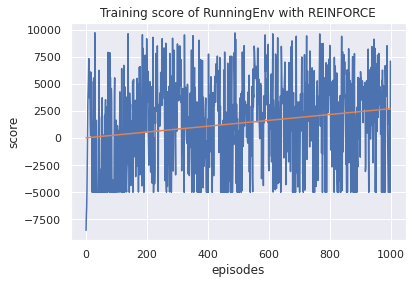

In [9]:
sns.set()

plt.plot(scores)
plt.ylabel('score')
plt.xlabel('episodes')
plt.title('Training score of RunningEnv with REINFORCE')

reg = LinearRegression().fit(np.arange(len(scores)).reshape(-1, 1), np.array(scores).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(scores)).reshape(-1, 1))
plt.plot(y_pred)
plt.show()

#### Trying Agent:

In [12]:
done = False
state = env.reset()
scores = []

for _ in tqdm(range(50)):
    env.reset()
    state = env.step(0, pref_pace)[1]
    done = False
    score = 0

    for i in range(FRAMES):
        # env.render()
        action, lp = select_action(network, state)
        print(action)
        _, new_state, reward, _, done = env.step(action, pref_pace)
        score += reward
        state = new_state
    scores.append(score)

  0%|          | 0/50 [00:00<?, ?it/s]

TypeError: step() takes 2 positional arguments but 3 were given

In [22]:
np.array(scores).mean()

357.96

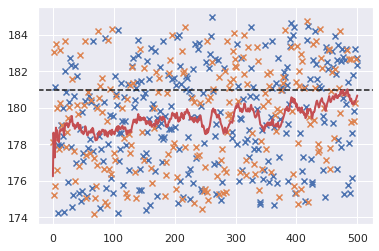

567.0


In [25]:
env.reset()
state_traj = np.empty(0)
state = env.step(0, pref_pace)[1]
pace = np.empty(0)
rewards = np.empty(0)
env_pacing = np.empty(0)
pacing = []

for y in range(500):
    action, lp = select_action(network, state)
    current_pace, new_state, reward, real_pacing, done = env.step(action, pref_pace)
    state_traj = np.append(state_traj, (new_state[0]+1)*pref_pace)
    pace = np.append(pace, current_pace)
    rewards = np.append(rewards, reward)
    env_pacing = np.append(env_pacing, real_pacing)
    state = new_state
    pacing.append(action)

x = np.linspace(0, len(pacing), len(pacing))
plt.scatter(x[np.array(pacing)==1], np.array(pace)[np.array(pacing)==1], marker="x", label='Paced steps')
plt.scatter(x[np.array(pacing)==0], np.array(pace)[np.array(pacing)==0], marker="x", label='Not-paced steps')


# plt.scatter(x[np.array(env_pacing)==1], np.array(pace)[np.array(env_pacing)==1], marker="x", label='Paced steps')
# plt.scatter(x[np.array(env_pacing)==0], np.array(pace)[np.array(env_pacing)==0], marker="x", label='Not-paced steps')

# plt.scatter(x[np.array(pacing)==1], np.array(pacing)[np.array(pacing)==1]*181, color='r', marker="x")
plt.axhline(y=181, color='k', linestyle='--', label='Target Pace')

plt.plot(x, state_traj, 'r-', linewidth=2)
plt.show()

print(np.sum(rewards))

### Trying Heuristic agent

In [12]:
class HeuristicAgent:
    def __init__(self):
        self.initial_wait = 20
        self.initial_completed = False

    def select_action(self, state):
        avg_pace = state[0]
        remaining_activation = state[1]
        action = 0

        # Initial waiting time
        if not(self.initial_completed):
            self.initial_wait = self.initial_wait - 1
            if self.initial_wait == 0:
                self.initial_completed = True

        if abs(avg_pace) > 15e-3:
            if (remaining_activation == -1) | (remaining_activation > 0.5):
                action = 1

        return action

In [13]:
heuristic_agent = HeuristicAgent()
print(heuristic_agent.select_action([0.013, -1]))

0


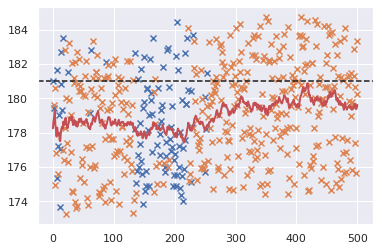

589.0


In [14]:
env.reset()
heuristic_agent = HeuristicAgent()
state_traj = np.empty(0)
state = env.step(0, pref_pace)[1]
pace = np.empty(0)
rewards = np.empty(0)
env_pacing = np.empty(0)
pacing = []

for y in range(500):
    action = heuristic_agent.select_action(state)
    current_pace, new_state, reward, real_pacing, done = env.step(action, pref_pace)
    state_traj = np.append(state_traj, (new_state[0]+1)*pref_pace)
    pace = np.append(pace, current_pace)
    rewards = np.append(rewards, reward)
    env_pacing = np.append(env_pacing, real_pacing)
    state = new_state
    pacing.append(action)

x = np.linspace(0, len(pacing), len(pacing))
# plt.scatter(x[np.array(pacing)==1], np.array(pace)[np.array(pacing)==1], marker="x", label='Paced steps')
# plt.scatter(x[np.array(pacing)==0], np.array(pace)[np.array(pacing)==0], marker="x", label='Not-paced steps')


plt.scatter(x[np.array(env_pacing)==1], np.array(pace)[np.array(env_pacing)==1], marker="x", label='Paced steps')
plt.scatter(x[np.array(env_pacing)==0], np.array(pace)[np.array(env_pacing)==0], marker="x", label='Not-paced steps')

# plt.scatter(x[np.array(pacing)==1], np.array(pacing)[np.array(pacing)==1]*181, color='r', marker="x")
plt.axhline(y=181, color='k', linestyle='--', label='Target Pace')

plt.plot(x, state_traj, 'r-', linewidth=2)
plt.show()

print(np.sum(rewards))

In [15]:
done = False
state = env.reset()
heuristic_agent = HeuristicAgent()
scores = []

for _ in tqdm(range(50)):
    env.reset()
    state = env.step(0, pref_pace)[1]
    done = False
    score = 0

    for i in range(FRAMES):
        # env.render()
        action = heuristic_agent.select_action(state)
        _, new_state, reward, _, done = env.step(action, pref_pace)
        score += reward
        state = new_state
    scores.append(score)

  0%|          | 0/50 [00:00<?, ?it/s]

In [16]:
print(np.mean(scores))

459.62
